In [2]:
# import the packages needed
# !pip3 install torch
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/millerm/.local/lib/python3.10/site-packages')

import torch
import torchvision

In [3]:
#!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

In [4]:
import torch.nn as nn
from torchinfo import summary
import torchvision.transforms as transforms


In [5]:
from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

In [8]:
from torchvision.models import VGG16_Weights
model = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)

In [9]:
trans_wo_norm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset0_wo_norm = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/train/", transform=trans_wo_norm)
dataset1_wo_norm = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/test/", transform=trans_wo_norm)
dataset2_wo_norm = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/val/", transform=trans_wo_norm)

In [25]:
mean0 = torch.zeros(3)
std0 = torch.zeros(3)
for img, _ in dataset0_wo_norm:
    mean0 += img.mean(dim=(1, 2))
    std0 += img.std(dim=(1, 2))

mean0 /= len(dataset0_wo_norm)
std0 /= len(dataset0_wo_norm)

print("Mean:", mean0)
print("Standard deviation:", std0)

# Mean: tensor([0.5832, 0.5832, 0.5832])
# Standard deviation: tensor([0.1413, 0.1413, 0.1413])

Mean: tensor([0.5832, 0.5832, 0.5832])
Standard deviation: tensor([0.1413, 0.1413, 0.1413])


In [23]:
mean1 = torch.zeros(3)
std1 = torch.zeros(3)
for img, _ in dataset1_wo_norm:
    mean1 += img.mean(dim=(1, 2))
    std1 += img.std(dim=(1, 2))

mean1 /= len(dataset1_wo_norm)
std1 /= len(dataset1_wo_norm)

print("Mean:", mean1)
print("Standard deviation:", std1)

# Mean: tensor([0.5763, 0.5763, 0.5763])
# Standard deviation: tensor([0.1453, 0.1453, 0.1453])

Mean: tensor([0.5763, 0.5763, 0.5763])
Standard deviation: tensor([0.1453, 0.1453, 0.1453])


In [24]:
mean2 = torch.zeros(3)
std2 = torch.zeros(3)
for img, _ in dataset2_wo_norm:
    mean2 += img.mean(dim=(1, 2))
    std2 += img.std(dim=(1, 2))

mean2 /= len(dataset2_wo_norm)
std2 /= len(dataset2_wo_norm)

print("Mean:", mean2)
print("Standard deviation:", std2)

# Mean: tensor([0.6020, 0.6020, 0.6020])
# Standard deviation: tensor([0.1401, 0.1401, 0.1401])

Mean: tensor([0.6020, 0.6020, 0.6020])
Standard deviation: tensor([0.1401, 0.1401, 0.1401])


In [10]:
mean0 =torch.tensor([0.5832, 0.5832, 0.5832])
std0  =torch.tensor([0.1413, 0.1413, 0.1413])
mean1 =torch.tensor([0.5763, 0.5763, 0.5763])
std1  =torch.tensor([0.1453, 0.1453, 0.1453])
mean2 =torch.tensor([0.6020, 0.6020, 0.6020])
std2  =torch.tensor([0.1401, 0.1401, 0.1401])

In [11]:
std_normalise_0 = transforms.Normalize(
    mean=mean0,
    std=std0
)
std_normalise_1 = transforms.Normalize(
    mean=mean1,
    std=std1
)
std_normalise_2 = transforms.Normalize(
    mean=mean2,
    std=std2
)

trans0 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        std_normalise_0
])
trans1 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        std_normalise_1
])
trans2 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        std_normalise_2
])

In [12]:
dataset_0 = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/train/", transform=trans0)
dataset_1 = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/test", transform=trans1)
dataset_2 = torchvision.datasets.ImageFolder("ml4h_data/project1/chest_xray/chest_xray/val", transform=trans2)

In [13]:
def display_dataset(dataset, n=2,classes=('NORMAL','PNEUMONIA')):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


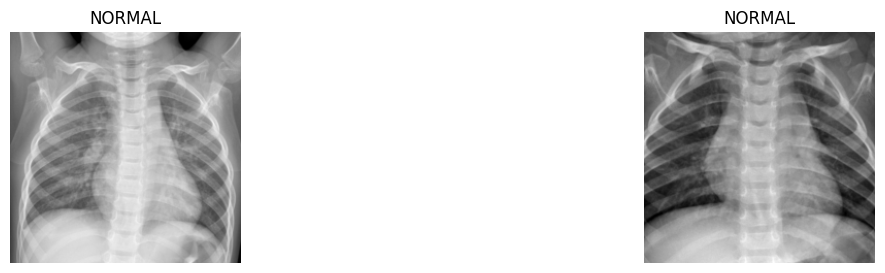

In [14]:
display_dataset(dataset_0)

In [20]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

model.to(device)

Doing computations on device = cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
model.classifier = nn.Sequential(
    torch.nn.Linear(25088,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace = False),
    torch.nn.Linear(4096,1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace = False),
    torch.nn.Linear(1000,2)
).to(device)

In [17]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.001,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


In [25]:
train_loader = torch.utils.data.DataLoader(dataset_0,batch_size=32)
val_loader = torch.utils.data.DataLoader(dataset_2,batch_size=32)
# note that the validation set is small and we achieve an accuracy of 0.5 for every model
# below the training data will be split into training and validation set for better understanding of model

In [26]:
# !!! # takes a minute or two

# print all labels of train_loader to extract length of NORMAL and PNEUMONIA cases
all_labels = []
for batch_data, batch_labels in train_loader:
    # 'batch_data' contains input data (images or other features)
    # 'batch_labels' contains corresponding target labels

    # Extract target labels and append to the list
    all_labels.extend(batch_labels.tolist())

In [27]:
print(torch.tensor(all_labels).sum(),torch.tensor(all_labels).shape)

tensor(3875) torch.Size([5216])


In [18]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [30]:
for param in model.features.parameters():
    param.requires_grad = False

In [31]:
# access any layer or change as needed
# model.features[29] = nn.ReLU(inplace=True)
model.features[29]

ReLU(inplace=True)

In [23]:
# now we define train and validation set randomly as the validation set provided is too small for meaningful results
trainset, testset = torch.utils.data.random_split(dataset_0, [4999, len(dataset_0) - 4999])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=32)
test_loader  = torch.utils.data.DataLoader(testset,batch_size=32)

In [25]:
default_device = device
train_long(model,train_loader,test_loader,lr=0.00005,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.9375, train loss = 0.004200848285108805
Epoch 0, minibatch 90: train acc = 0.9756181318681318, train loss = 0.001991816601910434
Epoch 0 done, validation acc = 0.9723502304147466, validation loss = 0.0029674257550920758


In [ ]:
torch.save(model,'model.pth')

In [24]:
# !!! # 
# each of the below steps will take a couple of minutes

# trying out additional models

from torchvision.models import alexnet, AlexNet_Weights
alex = torchvision.models.alexnet(weights=AlexNet_Weights.DEFAULT)
alex = alex.to(device)
train_long(alex,train_loader,test_loader,lr=0.001,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.0, train loss = 0.4130125939846039
Epoch 0, minibatch 90: train acc = 0.790521978021978, train loss = 0.03025703115777655
Epoch 0 done, validation acc = 0.7373271889400922, validation loss = 0.015992767799834502


In [22]:
from torchvision.models import resnet50, ResNet50_Weights
res = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
res = res.to(device)
train_long(res,train_loader,test_loader,lr=1e-3,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.0, train loss = 0.2240595817565918
Epoch 0, minibatch 90: train acc = 0.9247939560439561, train loss = 0.010942915638724526
Epoch 0 done, validation acc = 0.8940092165898618, validation loss = 0.009095695710951281


In [17]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.to(device)
model.eval()

Using cache found in /home/millerm/.cache/torch/hub/pytorch_vision_v0.6.0
/home/millerm/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/millerm/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
model.classifier = nn.Sequential(
    torch.nn.Linear(1280,2560),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(2560,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,2)
).to(device)

train_long(model, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.021455146372318268
Epoch 0, minibatch 90: train acc = 0.9515796703296703, train loss = 0.004187560015982324


In [19]:
model.classifier = nn.Sequential(
    torch.nn.Linear(1280,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace = False),
    torch.nn.Linear(4096,1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5, inplace = False),
    torch.nn.Linear(1000,2)
).to(device)
default_device = device
train_long(model, train_loader, test_loader, lr = 1e-3, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

Epoch 0, minibatch 0: train acc = 0.34375, train loss = 0.023660307750105858
Epoch 0, minibatch 90: train acc = 0.9144917582417582, train loss = 0.007326667780404562
Epoch 0 done, validation acc = 0.9815668202764977, validation loss = 0.0013352198534846856


In [18]:
# accessing layers of the CNN
model.features[16].conv[0][0]

Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)